In [ ]:
!pip install -q kagglehub torch lightning wandb

## Load dataset from Kaggle

In [1]:
from torchvision import transforms as T
from kagglehub import dataset_download

path = dataset_download("shubham1921/real-to-ghibli-image-dataset-5k-paired-images")
print("Path to dataset files:", path)

domain_a = f"{path}/dataset/trainA"
domain_b = f"{path}/dataset/trainB_ghibli"

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/shubham1921/real-to-ghibli-image-dataset-5k-paired-images/versions/1


## Convert the data into Lightning Modules

In [2]:
from data.dataset import UnpairedImageDataset
from data.datamodule import UnpairedDataModule

datamodule = UnpairedDataModule(
    domain_a_dir=domain_a,
    domain_b_dir=domain_b,
    batch_size=1,
    num_workers=1
)

datamodule.setup()

/opt/conda/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
batch = next(iter(datamodule.train_dataloader()))
print("Domain A batch shape:", batch["a"].shape)
print("Domain B batch shape:", batch["b"].shape)

Domain A batch shape: torch.Size([1, 3, 256, 256])
Domain B batch shape: torch.Size([1, 3, 256, 256])


### Check resized image

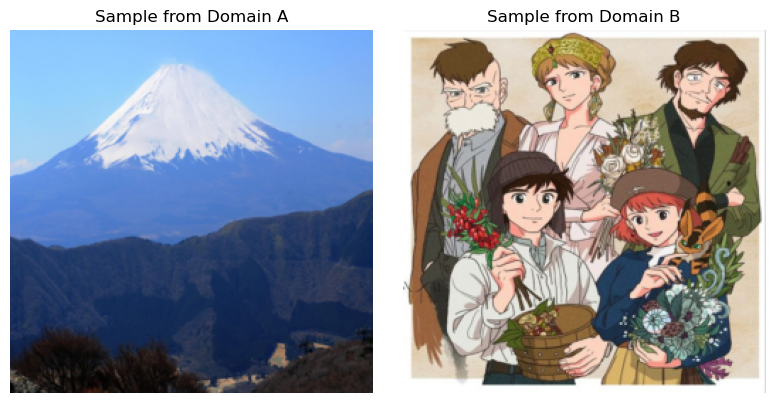

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def denormalize(tensor):
    return tensor * 0.5 + 0.5 

a_tensor = batch["a"][0]
b_tensor = batch["b"][0]

a_img = denormalize(a_tensor).permute(1, 2, 0).numpy()
b_img = denormalize(b_tensor).permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(a_img)
axs[0].set_title("Sample from Domain A")
axs[0].axis("off")

axs[1].imshow(b_img)
axs[1].set_title("Sample from Domain B")
axs[1].axis("off")

plt.tight_layout()
plt.show()

# Training

In [5]:
import cycleGAN

## Example Training

In [ ]:
training = cycleGAN.Training("sample-training", cycleGAN.TrainableCycleGAN(cycleGAN.CycleGANConfig(), cycleGAN.TrainConfig()), datamodule)

In [ ]:
training()

## Example Sweep

In [6]:
from cycleGAN.training_defaults import  ENTITY_NAME, PROJECT_NAME

In [7]:
sweep_config = {
    "name": "sample-sweep",
    "method": "random",
    "metric": {"name": "valid_loss", "goal": "minimize"},
    "parameters": {
        "max_epochs": {"value": 200},
        "start_epoch": {"value": 0},
        "decay_epoch": {"value": 100},
        "learning_rate": {
            "min": 1e-5,
            "max": 1e-3,
            "distribution": "log_uniform_values",
        },
        "lambda_a": {"values": [10.0]},
        "lambda_b": {"values": [10.0]},
        "lambda_identity": {"values": [0.5]},
    },
}

In [8]:
sweep = cycleGAN.Sweep("sample-sweep", PROJECT_NAME, ENTITY_NAME, cycleGAN.CycleGANConfig(), sweep_config, datamodule, count=1)

In [9]:
sweep()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: t01qfws7
Sweep URL: https://wandb.ai/cvai-ganerate-your-dreams/ganerate-your-dreams/sweeps/t01qfws7


wandb: Agent Starting Run: 9ih3rknx with config:
wandb: 	decay_epoch: 100
wandb: 	lambda_a: 10
wandb: 	lambda_b: 10
wandb: 	lambda_identity: 0.5
wandb: 	learning_rate: 0.0002895775634058062
wandb: 	max_epochs: 200
wandb: 	start_epoch: 0
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: v8-luky (cvai-ganerate-your-dreams) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/opt/conda/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
lr-Adam-1,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
lr-Adam-1-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-1-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-2,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
lr-Adam-2-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-2-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁


## Example Evaluation

In [ ]:
# This might still  be subject to change

artifact_name = "6jei9w9o"
artifact_version = "v2"
artifact_path = f"{ENTITY_NAME}/{PROJECT_NAME}/{artifact_name}:{artifact_version}"

evaluation = cycleGAN.Evaluation("sample-eval", PROJECT_NAME, ENTITY_NAME, artifact_path, datamodule)
evaluation()